In [1]:
import math

import pymatgen as pmg
import numpy as np

import lammps

In [2]:
a = 6
alpha = 90
lattice = pmg.Lattice.from_parameters(a, a, a, alpha, alpha, alpha)
symbols = ['Mg', 'O']
positions = [(0, 0, 0), (0.5, 0.5, 0.5)]

structure = pmg.Structure.from_spacegroup(225, lattice, symbols, positions)

In [3]:
structure

Structure Summary
Lattice
    abc : 6.0 6.0 6.0
 angles : 90.0 90.0 90.0
 volume : 216.0
      A : 6.0 0.0 3.6739403974420594e-16
      B : 9.64873589805982e-16 6.0 3.6739403974420594e-16
      C : 0.0 0.0 6.0
PeriodicSite: Mg (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Mg (0.0000, 3.0000, 3.0000) [0.0000, 0.5000, 0.5000]
PeriodicSite: Mg (3.0000, 0.0000, 3.0000) [0.5000, 0.0000, 0.5000]
PeriodicSite: Mg (3.0000, 3.0000, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: O (3.0000, 3.0000, 3.0000) [0.5000, 0.5000, 0.5000]
PeriodicSite: O (3.0000, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
PeriodicSite: O (0.0000, 3.0000, 0.0000) [0.0000, 0.5000, 0.0000]
PeriodicSite: O (0.0000, 0.0000, 3.0000) [0.0000, 0.0000, 0.5000]

In [8]:
def lammps_initialize(structure):
    lmp = lammps.Lammps(units='metal', args=[
        '-log', 'none',
        '-screen', 'none'
    ])
    lmp.command('atom_modify map yes id yes sort 10000 5.0')

    elements = [pmg.Element(symbol) for symbol in set(symbols)]

    # set unit cell
    lmp.box.from_lattice_const(len(elements), 
                               np.array(structure.lattice.abc),
                               np.array(structure.lattice.angles) * (math.pi/180))
    
    # set element mass
    for element, atom_type in zip(elements, lmp.system.atom_types):
        atom_type.mass = element.atomic_mass
    
    velocities = structure.site_properties.get('velocities')
    atom_types = np.array([elements.index(atom.specie)+1 for atom in structure], dtype=np.intc)
    lmp.system.create_atoms(atom_types, structure.cart_coords + 1e-6, velocities)
    return lmp

def add_ion(lmp):
    ion_velocity = np.random.random((1, 3)) * 100
    ion_position = np.array([1.5, 1.5, 1.5]).reshape(1, 3)
    ion_id = lmp.system.total + 1
    ion_atom_type = np.array([2], dtype=np.intc)
    lmp.system.create_atoms(ion_atom_type, ion_position, ion_velocity, start_index=ion_id) 
    lmp.command('group ion id %d' % ion_id)

In [9]:
lmp = lammps_initialize(structure)
add_ion(lmp)

script = """
pair_style  buck 10
pair_coeff 1 1 1309362.2766468062 0.104 0.0
pair_coeff 1 2 9892.357 0.20199 0.0
pair_coeff 2 2 2145.7345 0.3 30.2222

fix 1 all nve
"""
for line in script.split('\n'):
    lmp.command(line)

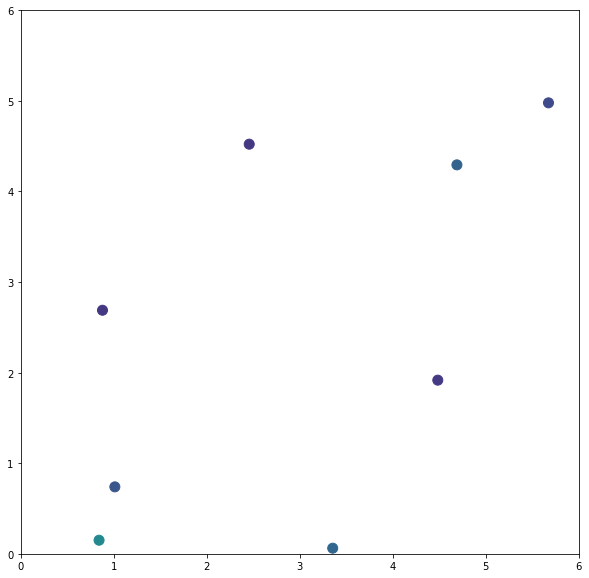

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

c = np.linalg.norm(lmp.system.velocities, axis=1)
c_min = np.min(c)
c_max = np.max(c)

def main():
    numframes = 100

    fig = plt.figure()
    fig.set_size_inches((10, 10))
    x = lmp.system.positions[:, 0].reshape(-1, 1)
    y = lmp.system.positions[:, 0].reshape(-1, 1)
    c = np.linalg.norm(lmp.system.velocities, axis=1).reshape(-1, 1)
    c_norm = (np.clip(c, c_min, c_max) - c_min) / (c_max - c_min)
    scat = plt.scatter(x, y, c=c_norm, s=100)
    plt.xlim((0, 6))
    plt.ylim((0, 6))

    ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes),
                                  fargs=(scat,))
    return HTML(ani.to_html5_video())

def update_plot(i, scat):
    lmp.run(3)
    
    # Delete ion after 50 frames
    if i == 50:
        lmp.command('delete_atoms group ion')
    
    x = lmp.system.positions[:, 0].reshape(-1, 1)
    y = lmp.system.positions[:, 1].reshape(-1, 1)
    c = np.linalg.norm(lmp.system.velocities, axis=1)
    c_norm = (np.clip(c, c_min, c_max) - c_min) / (c_max - c_min)
    diff = np.concatenate((x, y), axis=1)
    scat.set_array(c_norm)
    scat.set_offsets(diff)
    return scat,

main()